# TERRA-REF Image Stitching: From Workbench to HPC

<div style="float:left; margin-right: 20px">
<img src="field_scanner.jpg" style="width: 350px;">
</div>
<div> The ARPA-E TERRA-REF project provides a computing pipline for a LemnaTec Scanalyzer Field system deployed at the University of Arizona Maricopa Agricultural Center.  The Scanalyzer includes a set of stereo RGB cameras that produce over 10,000 images and hundreds of gigabytes of data for each run. The computing pipeline generates a daily fullfield overview image of the RGB data using the Geospatial Data Abstraction Library (GDAL) toolkit.  The TERRA-REF data is mounted on the ROGER CyberGIS system.

This notebook demonstrates how Labs Workbench can be used to "scale up" analysis, from exploratory work in a resource-constrained Docker container to running analysis "at scale" on HPC systems including ROGER and the XSEDE Comet system via Singularity.
</div>

# Image stitching

The process of image stitching is currently used in the TERRA-REF project for quality control. The full-field images confirm that the Scanalyzer platform and compute pipeline are operating as expected.  In the future, full-field images will also be used for the measurement of phenotypes.

In [113]:
import glob
import getpass
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from IPython.display import display
%matplotlib inline

# Case 1: Exploratory analysis in Labs Workbench

In this section, we demonstrate how exploratory anlaysis on the TERRA-REF dataset can be achieved using Labs Workbench alone. This is a resource-constrained Docker container for the Jupyter environment with a number of dependencies, including the GDAL toolkit.

## Display first 10 scanned images from RGB stereo camera

First, we'll display the first 10 scanned images from the RGB stereo camera. Note that source images are georeferenced GeoTIFFs, JPEGs are used here for illustration only.  Images are displayed in timestamp order, but scan is from south-east corner of field.

In [96]:
images = []
files = []
for img_path in sorted(glob.glob('images/2017-05-30/*/*_left.jpg')):
    files.append(img_path)
    images.append(mpimg.imread(img_path))

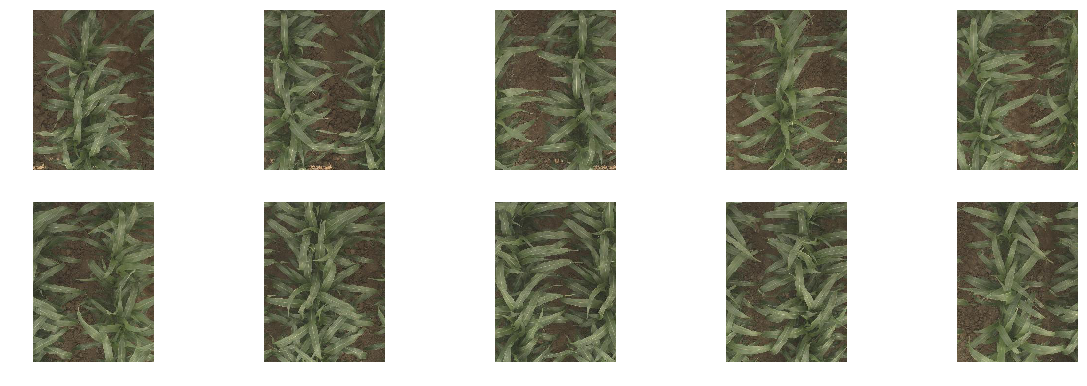

In [97]:
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.axis("off")
    plt.imshow(image)

## Use GDAL to build VRT then translate to merged GeoTIFF

In [100]:
! gdalbuildvrt  -srcnodata "-99 -99 -99" -overwrite -input_file_list images/input_2017-05-30.txt images/output_2017-05-30.vrt

0...10...20...30...40...50...60...70...80...90...100 - done.


In [101]:
! gdal_translate --config GDAL_CACHEMAX 999 images/output_2017-05-30.vrt images/output_2017-05-30.tif

Input file size is 1392, 331
0...10...20...30...40...50...60...70...80...90...100 - done.


In [102]:
! gdal_translate -outsize 50% 50% -of JPEG images/output_2017-05-30.tif images/output_2017-05-30.jpg

Input file size is 1392, 331
0...10...20...30...40...50...60...70...80...90...100 - done.


### Display the final stitched image

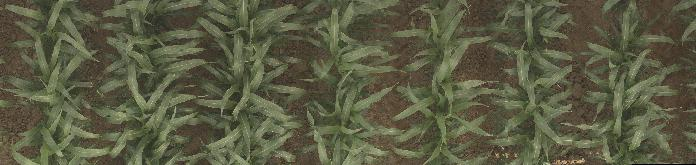

In [103]:
Image("images/output_2017-05-30.jpg") 

# Case 2: Running on ROGER HPC

The above example demonstrates how to stitch 10 images in a constrained Jupyter environment. A single day of TERRA-REF stereo RGB data contains over 8,000 images.  What if we want to stitch the full field image for a week or a month?

The TERRA-REF data is available on the ROGER HPC system at NCSA. The following example demonstrates how to use the Agave API from Jupyter to launch a batch processing job on ROGER.

In [67]:
agave_username = input()

willis8


In [68]:
agave_password = getpass.getpass()

········


In [ ]:
#!~/work/agave-cli/bin/tenants-init --tenant 3

In [81]:
!~/work/agave-cli/bin/auth-tokens-create -S  -u "$agave_username" -p "$agave_password"

Token for iplantc.org:willis8 successfully refreshed and cached for 14400 seconds
709be63a87b147257670bca4c6bc9c62


In [89]:
!~/work/agave-cli/bin/jobs-submit -F ../agave/roger-job.json

Successfully submitted job 6696596669096137191-242ac114-0001-007


In [92]:
! ~/work/agave-cli/bin/jobs-history 6696596669096137191-242ac114-0001-007

Job accepted and queued for submission.
Skipping staging. No input data associated with this job.
Preparing job for submission.
Attempt 1 to submit job
Fetching app assets from agave://willis8.roger-storage.ncsa//home/willis8/agave-apps/stitching-demo
Staging runtime assets to agave://willis8.roger.ncsa//gpfs/largeblockFS/projects/arpae/terraref/users/willis8/agave/willis8/job-6696596669096137191-242ac114-0001-007-stitch-8
HPC job successfully placed into batch queue as local job 79213.cg-gpu01
Job started running
Job completed execution
Job completed. Skipping archiving at user request.


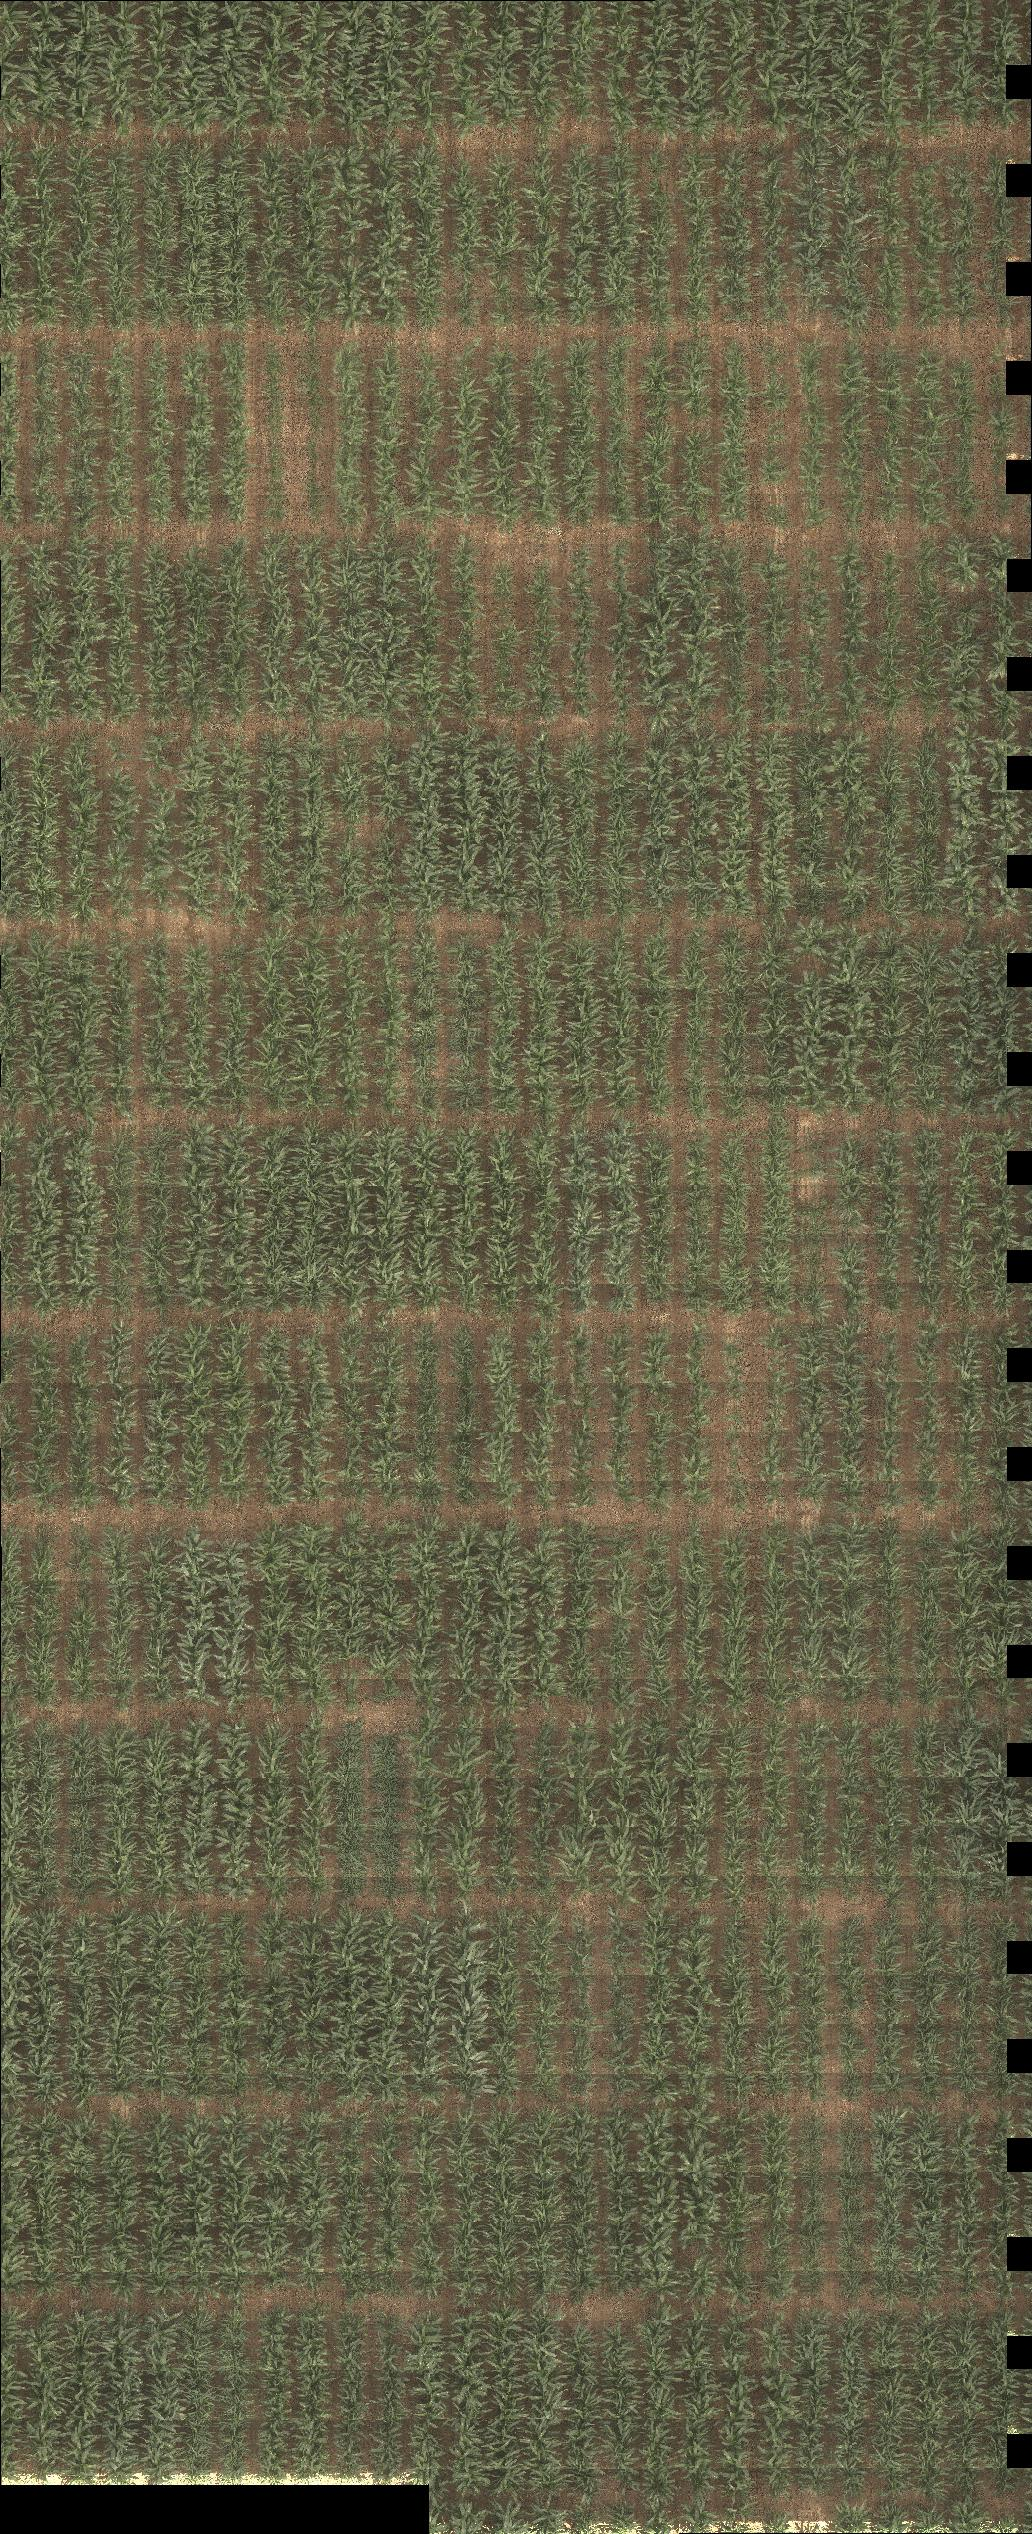

In [93]:
Image("/data/terraref/users/willis8/stitch/2017-05-30/stitch.jpg") 

# Case 3: Running via Singularity Container

The ROGER HPC integration requires all application dependencies to be installed and available on the HPC system.  What if our application uses libraries that aren't available on the host HPC? 

This example demonstrates launching the same job on the SDSC Comet system using Singularity.

In [104]:
!~/work/agave-cli/bin/jobs-submit -F ../agave/comet-job.json

Successfully submitted job 6486138667387654631-242ac114-0001-007


In [110]:
! ~/work/agave-cli/bin/jobs-history 6486138667387654631-242ac114-0001-007

Job accepted and queued for submission.
Skipping staging. No input data associated with this job.
Preparing job for submission.
Attempt 1 to submit job
Fetching app assets from agave://willis8.comet-storage.sdsc//home/willis8/agave-apps/stitching-demo
Staging runtime assets to agave://willis8.comet.sdsc//oasis/scratch/comet/willis8/temp_project/willis8/job-6486138667387654631-242ac114-0001-007-stitch
HPC job successfully placed into shared queue as local job 12446008
Job started running
Job completed execution
Job completed. Skipping archiving at user request.


In [111]:
!~/work/agave-cli/bin/files-get -S willis8.comet-storage.sdsc /oasis/scratch/comet/willis8/temp_project/stitch/2017-05-30/stitch.jpg

############################################################################################# 100.0%


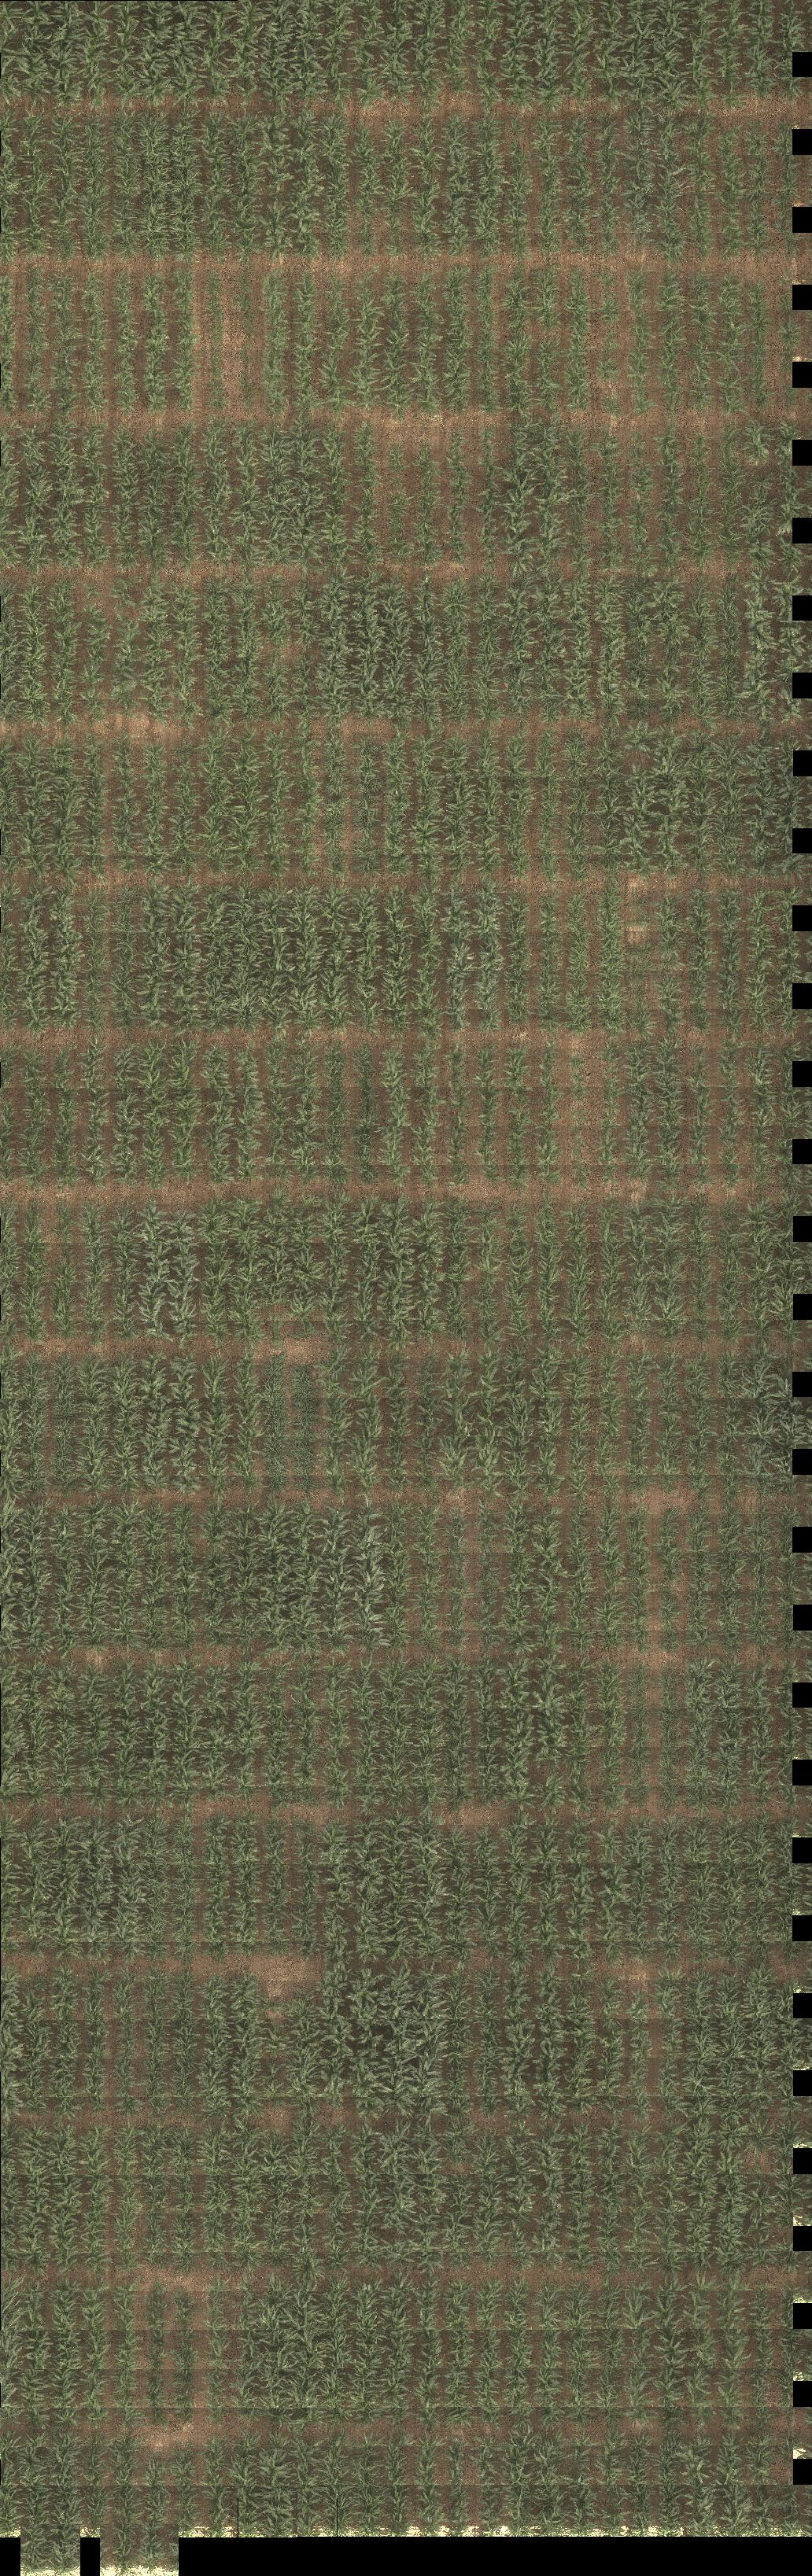

In [112]:
Image("stitch.jpg")

<hr>
<table width="100%" style="background-color:white">
<tr background-color="white">
<td width="20%" style="background-color:white"><img src="https://avatars2.githubusercontent.com/u/8526606?s=200&v=4" width="80px"></td>
<td width="20%" style="background-color:white"><img src="https://avatars0.githubusercontent.com/u/12563787?s=200&v=4" width="80px"></td>
<td width="20%" style="background-color:white"><img src="https://avatars3.githubusercontent.com/u/4095787?s=200&v=4" width="80px"></td>
<td width="20%" style="background-color:white"><img src="https://avatars2.githubusercontent.com/u/7528333?s=200&v=4" width="80px"></td>
<td width="20%" style="background-color:white"><img src="https://togo.agaveapi.co/auth/img/tenants/agave.prod-thumb.png" width="80px"></td>
</tr>
</table>
